In [67]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


In [65]:
dataset_root = '../../vcc2016/'

def extract_feature_vector(wav_file):    
    y, sr = librosa.load(wav_file, dtype=np.float64)

    feature_sequence = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    # Get the standard deviation
    stddev_features = np.std(feature_sequence, axis=1)

    # Get the mean
    mean_features = np.mean(feature_sequence, axis=1)

    # Get the average difference of the features
    average_difference_features = np.zeros((13,))
    for i in range(0, len(feature_sequence) - 2, 2):
        average_difference_features += feature_sequence[:, i] - feature_sequence[:, i+1]

    average_difference_features /= (len(feature_sequence[0]) // 2)   
    average_difference_features = np.array(average_difference_features)

    # Concatenate the features to a single feature vector
    concat_features_features = np.hstack((stddev_features, mean_features))
    concat_features_features = np.hstack((concat_features_features, average_difference_features))
    return concat_features_features

print(extract_feature_vector(input_file).shape)


(39,)


In [191]:
features = {}
#speakers = ['SF1', 'SF2', 'SF3', 'SM1', 'SM2', 'TF1', 'TF2', 'TM1', 'TM2', 'TM3']
#speakers = ['SF1', 'SM1', 'TF1', 'TM1']
speakers = ['SF2', 'TF1']
reconstructions = [(100024, 'SF2', 'SF2'), (100024, 'SF2', 'TF1')]

for speaker in speakers:
    speaker_dir = dataset_root + speaker + '/'
    speaker_features = []
    for f in os.listdir(speaker_dir):
        wav_path = speaker_dir + f
        speaker_features += [extract_feature_vector(wav_path)]
        
    features[speaker] = speaker_features

reconstructions_folder = 'generated/'
reconstruction_features = []
for reconstruction in reconstructions:
    id, source_id, target_id = reconstruction
    wav_path = dataset_root + reconstructions_folder + str(id) + "_" + source_id + "_" + target_id + ".wav"
    reconstruction_features += [extract_feature_vector(wav_path)]
    

In [192]:
#print(features['SF1'][0].shape)
#print(reconstruction_features[0].shape)
#print(len(list(features.values())))
#print(len(reconstruction_features))
all_features = np.vstack([np.concatenate(list(features.values())), reconstruction_features])
print(all_features.shape)

(326, 39)


(2, 326)


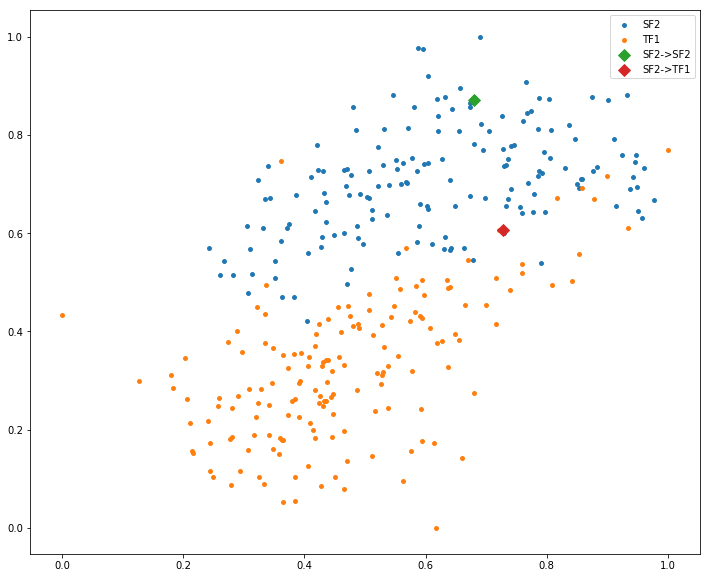

In [198]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

perplexity = 180
iterations = 500
points = np.transpose(get_scaled_tsne_embeddings(all_features, perplexity, iterations))
print(points.shape)
plt.figure(figsize=(12,10))
for i, speaker in enumerate(speakers):
    plt.scatter(points[0, i*162:(i+1)*162], points[1, i*162:(i+1)*162], label=speakers[i], s=15)
    
start_index = len(speakers)*162
for i, reconstruction in enumerate(reconstructions):
    label = reconstruction[1] + "->" + reconstruction[2]
    plt.scatter(points[0, start_index+i:start_index+1+i], points[1, start_index+i:start_index+1+i], label=label, s=70, marker='D')
plt.legend(loc='upper right')

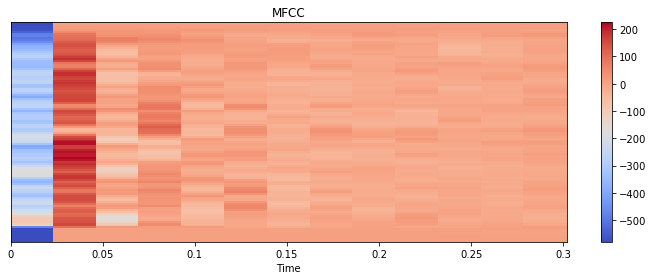

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()